Loaded CSV: C:\Users\aparn\Downloads\archive (1)\HousingData.csv shape: (506, 14)
['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

Final Model Coefficients:

Intercept: 32.679997
CRIM: -0.097594
ZN: 0.048905
INDUS: 0.030377
CHAS: 2.769384
NOX: -17.968995
RM: 4.283254
AGE: -0.012991
DIS: -1.458510
RAD: 0.285863
TAX: -0.013146
PTRATIO: -0.914582
B: 0.009656
LSTAT: -0.423661

MSE: 19.418398, RMSE: 4.406631, R^2: 0.767115



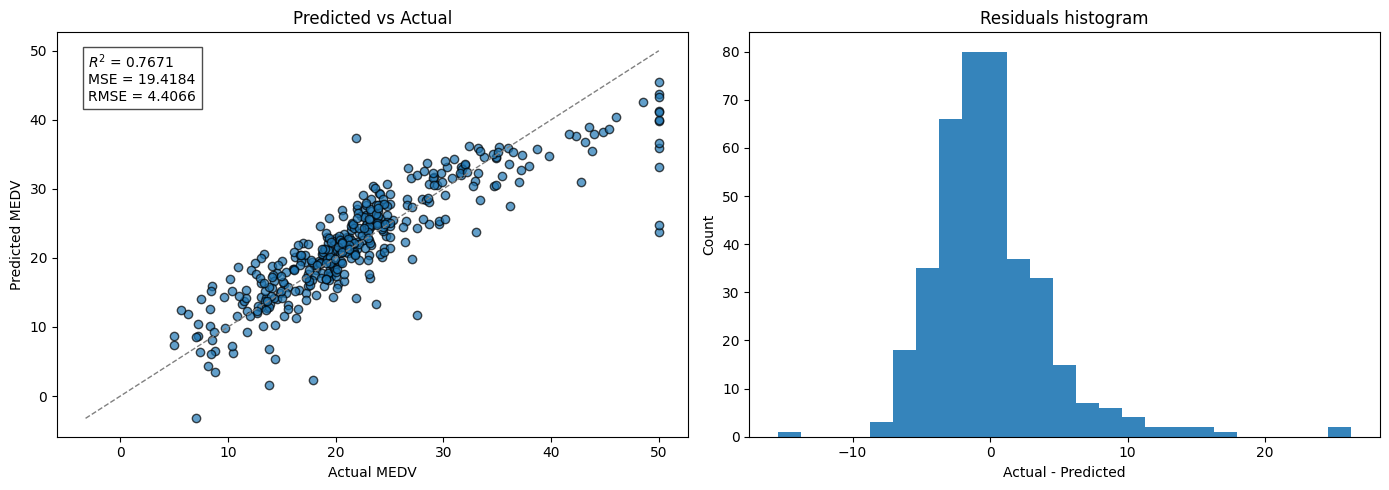

In [1]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

CSV_PATH = r"C:\Users\aparn\Downloads\archive (1)\HousingData.csv"

if not os.path.isfile(CSV_PATH):
    raise FileNotFoundError(f"CSV path not found: {CSV_PATH}")
df = pd.read_csv(CSV_PATH)
print("Loaded CSV:", CSV_PATH, "shape:", df.shape)
print(df.columns.tolist())

possible_target_names = ['MEDV', 'medv', 'PRICE', 'price', 'target', 'Target']
target_col = None
for c in df.columns:
    if c in possible_target_names:
        target_col = c
        break
if target_col is None:
    for c in df.columns:
        if 'med' in c.lower() or 'price' in c.lower() or 'target' in c.lower():
            target_col = c
            break
if target_col is None:
    raise ValueError("Could not find target column. Columns: " + ", ".join(df.columns))

features = [c for c in df.columns if c != target_col and c.lower() not in ['id','index']]
df = df[features + [target_col]].dropna().reset_index(drop=True)
X_df = df[features].copy()
y = df[target_col].astype(float).values.reshape(-1,1)

for col in list(X_df.columns):
    if X_df[col].dtype == object:
        try:
            X_df[col] = pd.to_numeric(X_df[col])
        except:
            dummies = pd.get_dummies(X_df[col], prefix=col, drop_first=True)
            X_df = pd.concat([X_df.drop(columns=[col]), dummies], axis=1)

X = X_df.values.astype(float)
n, p = X.shape

X_mean = X.mean(axis=0, keepdims=True)
X_std = X.std(axis=0, keepdims=True)
X_std[X_std == 0] = 1.0
Xs = (X - X_mean) / X_std
X_design = np.hstack([np.ones((n,1)), Xs])

def gradient_descent(Xd, y, lr=0.05, max_iters=20000, tol=1e-9, patience=500):
    n, d = Xd.shape
    theta = np.zeros((d,1))
    prev_loss = np.inf
    no_improve = 0
    for it in range(1, max_iters+1):
        preds = Xd @ theta
        errors = preds - y
        loss = (errors**2).mean()
        grad = (2.0 / n) * (Xd.T @ errors)
        theta = theta - lr * grad
        if abs(prev_loss - loss) < tol:
            no_improve += 1
        else:
            no_improve = 0
        if no_improve >= patience:
            break
        prev_loss = loss
    return theta

theta = gradient_descent(X_design, y, lr=0.05, max_iters=20000, tol=1e-9, patience=500)

b_scaled = float(theta[0,0])
w_scaled = theta[1:,0]
w_orig = w_scaled / X_std.ravel()
b_orig = b_scaled - (X_mean.ravel() @ (w_scaled / X_std.ravel()))
y_pred = (X @ w_orig.reshape(-1,1) + b_orig).ravel()

mse = ((y.ravel() - y_pred)**2).mean()
rmse = np.sqrt(mse)
ss_res = ((y.ravel() - y_pred)**2).sum()
ss_tot = ((y.ravel() - y.mean())**2).sum()
r_squared = 1 - ss_res/ss_tot

print("\nFinal Model Coefficients:\n")
print(f"Intercept: {b_orig:.6f}")
for i, col in enumerate(X_df.columns):
    print(f"{col}: {w_orig[i]:.6f}")
print(f"\nMSE: {mse:.6f}, RMSE: {rmse:.6f}, R^2: {r_squared:.6f}\n")

fig, axes = plt.subplots(1,2, figsize=(14,5))
axes[0].scatter(y, y_pred, alpha=0.7, edgecolor='k')
mn = min(y.min(), y_pred.min()); mx = max(y.max(), y_pred.max())
axes[0].plot([mn, mx], [mn, mx], linestyle='--', linewidth=1, color='gray')
axes[0].set_xlabel("Actual MEDV")
axes[0].set_ylabel("Predicted MEDV")
axes[0].set_title("Predicted vs Actual")
axes[0].text(0.05, 0.95, f"$R^2$ = {r_squared:.4f}\nMSE = {mse:.4f}\nRMSE = {rmse:.4f}",
             transform=axes[0].transAxes, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

residuals = y.ravel() - y_pred
axes[1].hist(residuals, bins=25, alpha=0.9)
axes[1].set_title("Residuals histogram")
axes[1].set_xlabel("Actual - Predicted")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()
